# Task 1.1: Prediction with RNN

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from src.load_data import get_data, load_daily_consumptions
from src.train import FederatedLearning
from src.config import Config, load_train_config

import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import torch
torch.manual_seed(101)

## Specify parameters

### Manually set config

In [4]:
kwargs = {
    # Main mode
    "mode": "prediction",

    # Model config
    "model": "RNN",  # LSTM or RNN
    "hidden_dim": 32,
    "num_layers": 1,
    "dropout": 0.0,

    # Training config
    "epochs": 1000,
    "lr": 3e-4,
    "batch_size": 128
}

config = Config(**kwargs)

In [5]:
# Save config
# config.save("default_pred_rnn")

### Load saved config

In [6]:
config = load_train_config("config_default_pred_rnn")
print(config)

Config loaded from: config/config_default_pred_rnn.json
CONFIG:
  mode: prediction
  test_size: 0.2
  val_size: 0.1
  shuffle: True
  seed: 42
  model: RNN
  input_dim: 1
  hidden_dim: 32
  output_dim: 1
  num_layers: 1
  dropout: 0.0
  epochs: 1000
  lr: 0.0003
  batch_size: 128
  eval_steps: 50


## Run FL training

In [7]:
x_train, x_val, x_test, y_train, y_val, y_test = get_data(config)

In [8]:
fl = FederatedLearning(config)
fl.train(x_train, y_train, x_val, y_val)

TRAIN:
  Epoch: 1,  train loss: 141.32799, val loss: 665.44879
  Epoch: 50,  train loss: 116.49046, val loss: 631.30676
  Epoch: 100,  train loss: 111.35426, val loss: 514.01666
  Epoch: 150,  train loss: 23.60154, val loss: 66.94907
  Epoch: 200,  train loss: 24.77463, val loss: 58.38889
  Epoch: 250,  train loss: 22.66065, val loss: 56.91312
  Epoch: 300,  train loss: 14.70448, val loss: 55.41048
  Epoch: 350,  train loss: 18.85611, val loss: 53.64981
  Epoch: 400,  train loss: 18.06785, val loss: 51.58434
  Epoch: 450,  train loss: 15.68882, val loss: 50.73308
  Epoch: 500,  train loss: 17.47280, val loss: 50.07452
  Epoch: 550,  train loss: 18.49281, val loss: 49.75063
  Epoch: 600,  train loss: 18.47977, val loss: 49.68550
  Epoch: 650,  train loss: 17.46437, val loss: 49.48973
  Epoch: 700,  train loss: 23.60389, val loss: 49.41882
  Epoch: 750,  train loss: 17.25061, val loss: 49.37534
  Epoch: 800,  train loss: 15.97275, val loss: 49.09836
  Epoch: 850,  train loss: 16.56656, v

### Analysis

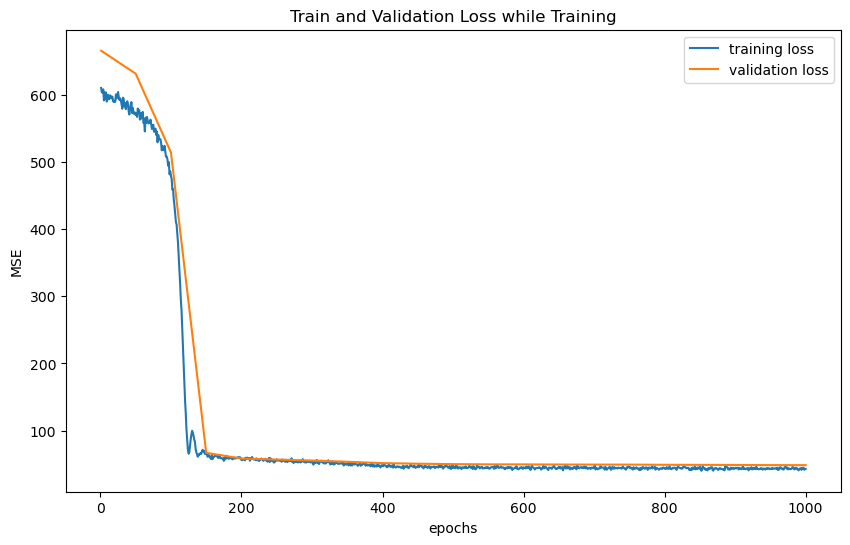

In [9]:
fl.plot_training_loss()

In [10]:
# TODO add "simulation plot": "show the predicted output vs. ground truth during the model training and testing"
daily_cons = load_daily_consumptions()
with torch.no_grad():
  daily_cons = torch.from_numpy(daily_cons).float()
daily_cons.shape

torch.Size([50, 366])

In [35]:
with torch.no_grad():
  # create windows
  windows, ground_truths = [], []
  window_size = 7
  time_ix = torch.arange(window_size, daily_cons.shape[1] - 1)
  for i in time_ix:
    window = daily_cons[:, i-window_size:i]
    windows.append(window)
    ground_truths.append(daily_cons[:, i])
  windows = torch.stack(windows)
  windows = windows.transpose(1, 0) # move household dimension to front

  # predict samples for windows (for that, the first two dimensions of the 
  # window tensor need to be combined such that we get a matrix instead of a 
  # 3-tensor)
  predictions = fl.model(windows.reshape(-1, window_size)).reshape(*windows.shape[:2])
  ground_truths = torch.stack(ground_truths)
  ground_truths = ground_truths.transpose(1, 0) # move household dimension to front
windows.shape, predictions.shape, ground_truths.shape

(torch.Size([50, 358, 7]), torch.Size([50, 358]), torch.Size([50, 358]))

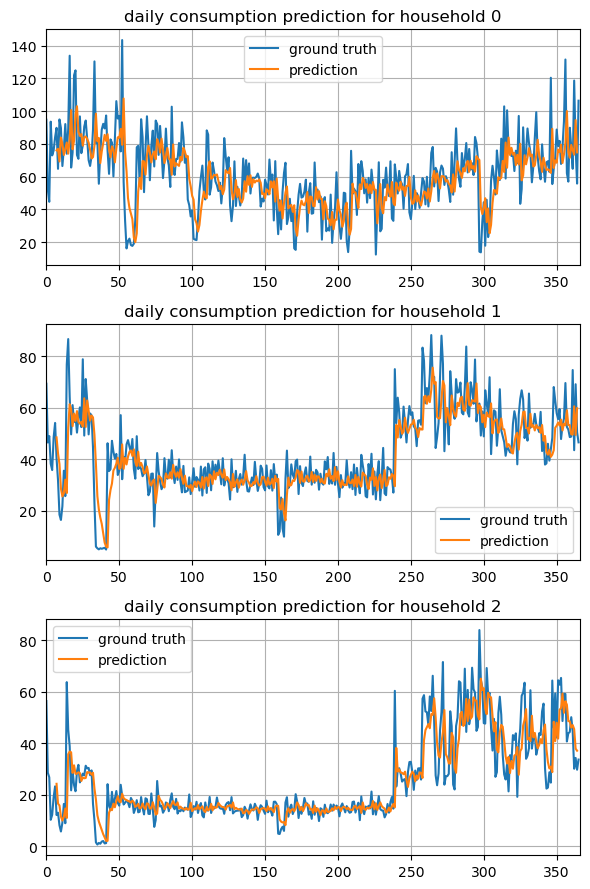

In [41]:
num_households = 15
plt.figure(figsize=(6,3 * num_households))

for h in range(num_households):
  plt.subplot(num_households, 1, h + 1)
  plt.xlim(0, daily_cons.shape[1])
  plt.grid(True)
  plt.title("daily consumption prediction for household %d" % h)

  # print ground truth and prediction
  plt.plot(daily_cons[h], label="ground truth")
  plt.plot(time_ix, predictions[h], label="prediction")

  plt.legend()
plt.tight_layout();

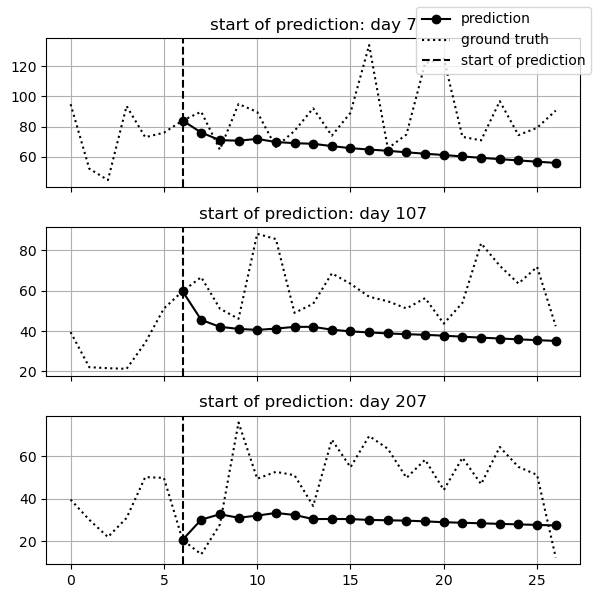

In [13]:
start_points = [0, 100, 200]
fig, axs = plt.subplots(nrows=len(start_points), figsize=(6, 2 * len(start_points)), sharex=True)
for start_idx, ax in zip(start_points, axs):
  window = windows[start_idx]
  completion = [w.item() for w in window]
  with torch.no_grad():
    for _ in range(20):
      pred = fl.model(torch.tensor(completion[-7:])[None,:])
      completion.append(pred.item())
  ax.grid(True)
  ax.plot(torch.arange(len(window) - 1, len(completion)), completion[len(window) - 1:], label="prediction", c="k", marker="o")
  ax.plot(daily_cons[0, start_idx:start_idx+len(completion)], label="ground truth", ls=":", c="k")
  ax.axvline(len(window) - 1, c="k", ls="--", label="start of prediction")
  ax.set_title("start of prediction: day {}".format(time_ix[start_idx]))
fig.legend(*ax.get_legend_handles_labels())
fig.tight_layout();

METRICS:
  Test MSE: 48.648006439208984


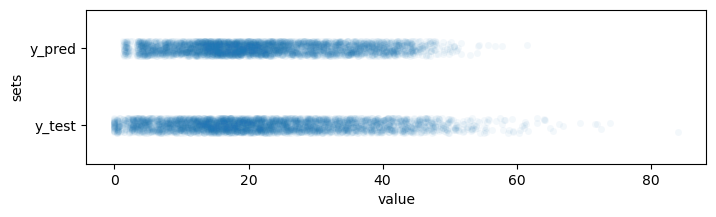

In [14]:
y_pred = fl.evaluation_metrics(x_test, y_test)
plt.figure(figsize=(8,2))
sns.stripplot(
  pd.DataFrame({"y_pred": y_pred.numpy()[:,0], "y_test": y_test.numpy().reshape(-1)}).melt(var_name="sets"),
  x="value", y="sets", alpha=.05,
);

## Run training with aggregated data

In [15]:
x_train, x_val, x_test, y_train, y_val, y_test = get_data(config)

# Stack data to aggregate all households to one
x_train, x_val, x_test = [arr.reshape(1, arr.shape[0] * arr.shape[1], arr.shape[2]) for arr in [x_train, x_val, x_test]]
y_train, y_val, y_test = [arr.reshape(1, arr.shape[0] * arr.shape[1]) for arr in [y_train, y_val, y_test]]

In [16]:
fl_agg = FederatedLearning(config)
fl_agg.train(x_train, y_train, x_val, y_val)

TRAIN:
  Epoch: 1,  train loss: 587.24750, val loss: 661.20990
  Epoch: 50,  train loss: 494.55728, val loss: 560.96295
  Epoch: 100,  train loss: 94.97276, val loss: 76.76189
  Epoch: 150,  train loss: 63.13353, val loss: 56.51381
  Epoch: 200,  train loss: 59.63903, val loss: 55.25549
  Epoch: 250,  train loss: 70.86913, val loss: 54.53723
  Epoch: 300,  train loss: 47.07889, val loss: 53.39510
  Epoch: 350,  train loss: 57.34948, val loss: 52.26633
  Epoch: 400,  train loss: 50.14190, val loss: 51.71451
  Epoch: 450,  train loss: 36.40447, val loss: 51.48223
  Epoch: 500,  train loss: 74.10422, val loss: 50.43115
  Epoch: 550,  train loss: 53.61292, val loss: 50.83100
  Epoch: 600,  train loss: 45.01258, val loss: 49.88587
  Epoch: 650,  train loss: 57.18838, val loss: 49.58055
  Epoch: 700,  train loss: 47.03132, val loss: 50.06513
  Epoch: 750,  train loss: 30.64028, val loss: 50.43444
  Epoch: 800,  train loss: 44.84451, val loss: 49.19388
  Epoch: 850,  train loss: 38.49899, val

### Analysis

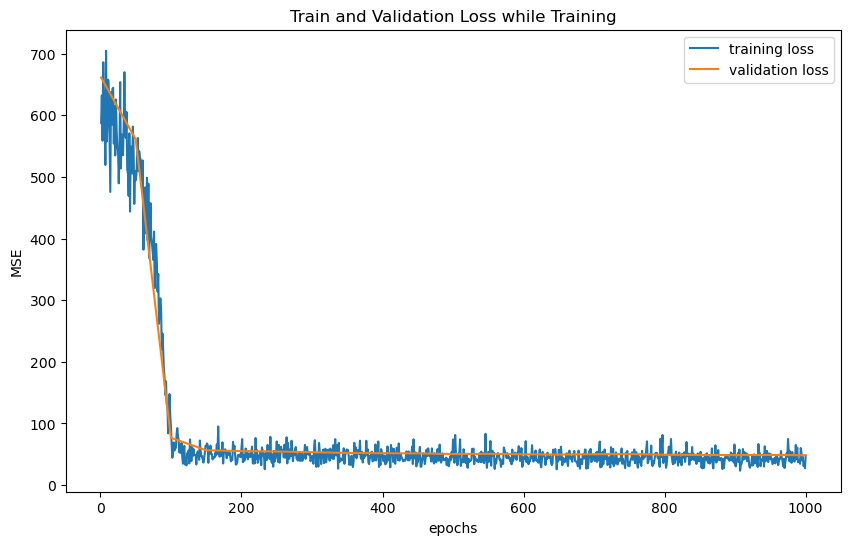

In [17]:
fl_agg.plot_training_loss()

In [18]:
y_pred = fl_agg.evaluation_metrics(x_test, y_test)

METRICS:
  Test MSE: 49.725914001464844
